<a href="https://colab.research.google.com/github/setthawut8/ai/blob/main/nlp/optimizer/%5Bclassify%5D_optimizer_bayessearchcv_tfidf_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

inspiration: https://github.com/nitsirs/debunker/blob/main/Notebooks/09%20Model%20_%20TF-IDF%20_%20SVM%20on%20LimeSoda.ipynb

In [1]:
%%capture
!pip install datasets
!pip install -q emoji pythainlp sklearn-pycrfsuite seqeval
!pip install tensorflow deepcut
!pip install scikit-optimize

#library

In [24]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pythainlp.tokenize import word_tokenize
from datasets import load_dataset, load_metric, DatasetDict, Dataset, load_from_disk

In [8]:
# [Social FSI] 
#download raw with translated
!gdown 1OFI-ki-2tuC929_DISgUoIRPMd5eDE0-#train
!gdown 1NqVSaMjJ50-8HwT9UKfM63qeoNhs23Kw #test

train = pd.read_excel('/content/translated_Text_train_FSI.xlsx', index_col=0)
test = pd.read_excel('/content/translated_Text_test_FSI.xlsx', index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1OFI-ki-2tuC929_DISgUoIRPMd5eDE0-#train
To: /content/translated_Text_train_FSI.xlsx
100% 5.22M/5.22M [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NqVSaMjJ50-8HwT9UKfM63qeoNhs23Kw
To: /content/translated_Text_test_FSI.xlsx
100% 169k/169k [00:00<00:00, 94.4MB/s]


In [14]:
train.head(1)

,Unnamed: 0.1,TagFile_Path,TagFile,SV_CustomerName,Main keyword,Channel,SubChannel,lfdn,verbatim_id,sentence_id,Text_original,Text,Human_Category,Human_CategoryID,Human_Sentiment,Human_SentimentID,Text_ws_local,translated
0,0,SocialFSI_ZE-KTB-Feb-Apr2022_Sampling2244_2022...,SocialFSI_ZE-KTB-Feb-Apr2022_Sampling1400_2022...,Krungthai_NEXT,"mobile banking+กสิกร,mobile banking+ธนาคารกสิก...",SocialMedia,forum,pantip.com_topic_41249919,Q2207_1549,Q2207_1549_1,สอบถามเรื่องการอายัดบัตรเดบิตของกสิกรค่ะ พอดีว...,สอบถามเรื่องการอายัดบัตรเดบิตของกสิกรค่ะ พอดีว...,"Product and Service, Usage and Condition",8,neutral,o,สอบถาม|เรื่อง|การ|อายัด|บัตรเดบิต|ของ|kbank|ค่...,I've been asking about the debit card holders....


In [15]:
test.head(1)

,Unnamed: 0.1,TagFile_Path,TagFile,SV_CustomerName,Main keyword,Channel,SubChannel,lfdn,verbatim_id,sentence_id,Text_original,Text,Human_Category,Human_CategoryID,Human_Sentiment,Human_SentimentID,Text_ws_local,translated
0,0,SocialFSI_v4_0_mutiple_train_sampling8203_2021...,SocialFSI_SV-FSI-20201101-29-20201201-25_Sampl...,NaN,NaN,SocialMedia,Pantip,5fdb2543b08b582c303ceba3,Q202106_4598,Q202106_4598_1,ในอนาคตธนาคารเกียรตินาคินภัทรจะมีบัตรเครดิตไหม...,ในอนาคตธนาคารเกียรตินาคินภัทรจะมีบัตรเครดิตไหม...,"Product and Service, Variety",10,neutral,o,ในอนาคต|ธนาคาร|kk|ภัทร|จะ|มี|บัตรเครดิต|ไหม|คร...,Is there a credit card in the future for honor...


In [36]:
labels = train['Human_CategoryID'].unique()

#preprocess

In [45]:
X = train['Text']
y = train['Human_CategoryID']

# without blank spaces
# def tokenizer(text):
#   tokens = word_tokenize(text,engine="deepcut")
#   tokens = [word for word in tokens if word != ' ']
#   return tokens

# with blank space
def tokenizer(text):
  return word_tokenize(text,engine="deepcut")

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
#เปลี่ยนข้อความเป็น bag-of-words features
tfidf = TfidfVectorizer(ngram_range=(1,2), tokenizer=word_tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)

In [41]:
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)
x_train, x_test

(<9720x21316 sparse matrix of type '<class 'numpy.float64'>'
 	with 526113 stored elements in Compressed Sparse Row format>,
 <2430x21316 sparse matrix of type '<class 'numpy.float64'>'
 	with 126190 stored elements in Compressed Sparse Row format>)

#model: BayesSearchCV

In [42]:
from skopt import BayesSearchCV
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

In [43]:
dfs = []
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)
opt.fit(x_train, y_train)
target_names = labels
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(x_test, y_test))

# ws w/o blank spaces 
# val. score: 0.6283950617283951
# test score: 0.6234567901234568

val. score: 0.6283950617283951
test score: 0.6234567901234568


In [44]:
print(f"best parameters: {str(opt.best_params_)}")

best parameters: OrderedDict([('C', 1000000.0), ('degree', 1), ('gamma', 1e-06), ('kernel', 'poly')])


In [50]:
test_x = test['Text']
test_y = test['Human_CategoryID']

#predict

In [53]:
test_x = tfidf.transform(test_x)
test_x

<389x21316 sparse matrix of type '<class 'numpy.float64'>'
	with 19583 stored elements in Compressed Sparse Row format>

In [55]:
preds = opt.predict(test_x)

#classification report and confusion matrix

In [66]:
label_dict = {id-1: label for id, label in zip(test['Human_CategoryID'].unique(), test['Human_Category'].unique())}
label_dict

{0: 'Accessibility',
 2: 'Company Brand',
 3: 'Staff Quality',
 4: 'Timing',
 5: 'Product and Service, Benefit',
 6: 'Product and Service, System',
 7: 'Product and Service, Usage and Condition',
 8: 'Product and Service, Convenience',
 9: 'Product and Service, Variety',
 10: 'Product and Service, Decision',
 11: 'Security',
 12: 'No Category'}

In [67]:
#convert a dict to an array
target_names = ["" for x in range(len(label_dict)+1)]

for id, label in label_dict.items():
  target_names[id] = label

#delete empty string for classification report
target_names = [label for label in target_names if label != ""]
target_names
print(len(target_names))

12


In [68]:
from sklearn.metrics import classification_report

print(classification_report(test_y, preds, target_names=target_names, zero_division=0))

                                          precision    recall  f1-score   support

                           Accessibility       1.00      0.29      0.44         7
                           Company Brand       0.67      0.17      0.27        12
                           Staff Quality       0.50      0.53      0.51        17
                                  Timing       0.72      0.75      0.74        28
            Product and Service, Benefit       0.76      0.50      0.60        32
             Product and Service, System       0.69      0.90      0.78        84
Product and Service, Usage and Condition       0.68      0.74      0.71        92
        Product and Service, Convenience       1.00      0.27      0.43        11
            Product and Service, Variety       0.67      0.17      0.27        12
           Product and Service, Decision       0.75      0.30      0.43        10
                                Security       0.00      0.00      0.00         3
               

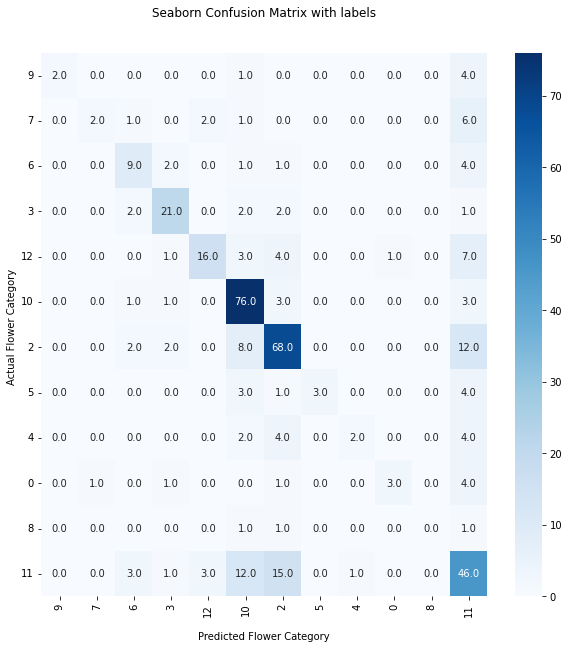

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(test_y, preds)

fig, ax = plt.subplots(figsize=(10,10))    
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=ax, fmt=".1f")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Flower Category')
ax.set_ylabel('Actual Flower Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label_dict, rotation=90)
ax.yaxis.set_ticklabels(label_dict, rotation=0)

## Display the visualization of the Confusion Matrix.
plt.show()

figure = ax.get_figure()    
figure.savefig("cf_matrix.png", pad_inches= 12, dpi=400)